## Supplementary Script 2: Calculate Root Diversity Score (RDS)

In [1]:
import os
import math
from collections import defaultdict, namedtuple
from itertools import combinations
from itertools import cycle
from scipy.special import comb
from scipy.stats import mannwhitneyu, combine_pvalues, pearsonr, kruskal
import scikit_posthocs as sp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as plticker
import seaborn as sns
from math import factorial
import csv
sns.set_style("white", {'axes.grid': True, 'grid.linestyle': u':'})
sns.set_style('ticks')
sns.set_context(rc={'lines.markeredgewidth': 0.1, 'patch.linewidth': 0.0})
%matplotlib inline

In [2]:
# path to phylogenetic topology file of original cohort (Supplementary Table 2)
topology_fp = 'Supplementary_Table_2.xlsx'
# path to phylogenetic topology file of validation cohort (Supplementary Table 5)
topology_fp_val = 'Supplementary_Table_5.xlsx'

if not os.path.isfile(topology_fp):
    print('ERROR: File {} needs to be in the same folder!'.format(clustering_fp))

colors = sns.color_palette()

In [3]:
# Methods to calculate Root Diversity Score (RDS)
def calculate_no_trees(n):
    """
    Function calculates the total number of distinct trees given by Edwards and Cavalli-Sforza, 1963
    :param n: number of samples
    :return number of distinct trees
    """
    return factorial((2*n)-3)/((2**(n-2))*factorial(n-2))

def calculate_no_common_trees(k, m):
    """
    Function calculates the number of monophyletic trees given by Theorem 3 in the SI
    :param k: number of remaining samples
    :param m: number of metastases samples
    :return number of distinct trees
    """
    return ((factorial(((2*k)-1)))/((2**(k-1))*(factorial(k-1))))*((factorial((2*m)-3))/((2**(m-2))*factorial(m-2)))

def cluster_probability(k, m):
    """
    Calculates the probability that a tree where all m metastases form a cluster (have one root) exists by chance
    :param k: number of remaining cancer samples of the same phylogeny
    :param m: number of metastases samples
    :return probabilility of cluster by chance
    """
    n = k + m
    
    no_trees = calculate_no_common_trees(k, m)
    
    return no_trees / calculate_no_trees(n)

def multibinomial(m, l, cluster_numbers):
    """
    Calculate the product of the binomials
    :param m: number of remaining cancer samples
    :param l: size of observed metastases cluster
    :param cluster_numbers: list of possible coexisting clusters of size l for a given phylogeny
    :return product of binomials
    """
    mb = 1
    for c in range(cluster_numbers):
        mb *= comb(m - c * l, l)
    return mb

def no_trees_with_clusters(k, clusters):
    """
    Calculates the number of trees where m1, m2, ..., mC, metastases form a cluster (have one root)
    :param k: number of remaining cancer samples of the same phylogeny
    :param m: list of number of metastases samples per C clusters
    :return number of trees where the given clusters have independent origin
    """
    n = k + sum(clusters)
    
    no_trees = 1
    for c in clusters:
        no_trees *= factorial(2 * c - 3) / (2**(c-2) * factorial(c - 2))
        
    no_trees *= (factorial((2*k) + (2 * len(clusters) - 3)) 
                 / (2**(k + (len(clusters) - 2)) * factorial(k + (len(clusters) - 2))))
    
    return no_trees

def no_trees_min_cluster(k, m, l):
    """
    Calculates the number of trees where m metastases form a cluster of size at least l
    Implements Formula (S1) from SI...
    :param k: number of primary tumor region samples
    :param m: number of metastases samples
    :param l: minimal cluster size
    :return number of distinct tree topologies where l out of m metastases form a cluster
    """
    
    n = k + m
    
    if l == 1:
        return calculate_no_trees(n)
    elif l < 1:
        raise RuntimeError('Size of largest cluster l can not be smaller than 1: {}'.format(l))
    
    no_trees = 0
    for no_clusters in range(1, int(math.floor(m / l)+1)):
        no_trees += ((-1)**(no_clusters-1) * multibinomial(m, l, no_clusters) / factorial(no_clusters) 
                     * no_trees_with_clusters(n - (no_clusters * l), [l for _ in range(no_clusters)]))
        
#         print('No trees after {}. iteration: {}'.format(cluster_number, no_trees))
    
    return no_trees

def rds(k, m, l):
    """
    Calculates the root diversity scores as the probability that a tree 
    where l metastases form a cluster (have one root) exists by chance 
    as defined by Equation (2)
    :param k: number of primary tumor region samples
    :param m: total number of metastases samples
    :param l: number of metastases that actually cluster together
    :return probabilility that a cluster of size l arises by chance
    """
    
    if l == 1:
        return 1
    elif l < 1:
        raise RuntimeError('Size of largest cluster l can not be smaller than 1: {}'.format(l))
    
    n = k + m
    
    no_trees = no_trees_min_cluster(k, m, l)
    
    # uses the result from equation (S1) and implements equation (S2)
    return no_trees / calculate_no_trees(n)

In [4]:
# correctness check of implementation
assert calculate_no_trees(5) == 105
assert calculate_no_trees(6) == 945

assert no_trees_with_clusters(2, [2, 2]) == 15, \
    'The number of trees with two clusters of size 2 should be 15 for k=2, m=4: {}'.format(
        no_trees_with_clusters(2, [2, 2]))
    
assert no_trees_min_cluster(2, 3, 2) == 45, \
    'The number of trees with a cluster of size at least 2 should be 45 for k=2, m=3: {}'.format(
        no_trees_min_cluster(2, 3, 2))
    
assert no_trees_min_cluster(2, 4, 2) == 585, \
    'The number of trees with a cluster of size at least 2 should be 585 for k=2, m=6: {}'.format(
        no_trees_min_cluster(2, 4, 2))
    
assert no_trees_min_cluster(2, 6, 2) == 114975, \
    'The number of trees with a cluster of size at least 2 should be 585 for k=2, m=6: {}'.format(
        no_trees_min_cluster(2, 6, 2))

### Apply root diversity score formula to example values

In [5]:
# Examples as given in Section 4 of the Supplementary Modeling
k = 2
m = 3
l = 3
print('For m={} metastases and k={} other samples, there are {:.0f} topologies of which {:.0f} exhibit a cluster of size at least {}.'.format(
    m, k, calculate_no_trees(k+m), no_trees_min_cluster(k, m, l), l))
print('RDS for {} out of {} metastases clustering together when there are {} other samples: {:.4e}'.format(
    l, m, k, rds(k, m, l)))

# second example
k = 3
print('For m={} metastases and k={} other samples, there are {:.0f} topologies of which {:.0f} exhibit a cluster of size at least {}.'.format(
    m, k, calculate_no_trees(k+m), no_trees_min_cluster(k, m, l), l))
print('RDS for {} out of {} metastases clustering together when there are {} other samples: {:.4e}'.format(
    l, m, k, rds(k, m, l)))

# third example
l = 1
print('For m={} metastases and k={} other samples, there are {:.0f} topologies of which {:.0f} exhibit a cluster of size at least {}.'.format(
    m, k, calculate_no_trees(k+m), no_trees_min_cluster(k, m, l), l))
print('RDS for {} out of {} metastases clustering together when there are {} other samples: {:.4e}'.format(
    l, m, k, rds(k, m, l)))

For m=3 metastases and k=2 other samples, there are 105 topologies of which 9 exhibit a cluster of size at least 3.
RDS for 3 out of 3 metastases clustering together when there are 2 other samples: 8.5714e-02
For m=3 metastases and k=3 other samples, there are 945 topologies of which 45 exhibit a cluster of size at least 3.
RDS for 3 out of 3 metastases clustering together when there are 3 other samples: 4.7619e-02
For m=3 metastases and k=3 other samples, there are 945 topologies of which 945 exhibit a cluster of size at least 1.
RDS for 1 out of 3 metastases clustering together when there are 3 other samples: 1.0000e+00


In [6]:
k = 4
m = 4
l = 4
print('RDS for {} out of {} metastases clustering together when there are {} other samples: {:.4e}'.format(
    l, m, k, rds(k, m, l)))

RDS for 4 out of 4 metastases clustering together when there are 4 other samples: 1.1655e-02


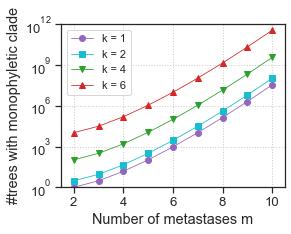

In [7]:
# Create figure demonstrating the relationship between the number of distinct tree topologies
# with the number of metastases samples and remaining cancer samples

# maximum number of primary tumor region samples (max k) to be plotted
no_pts = 6
pt_samples = [1, 2, 4, 6]
# maximum number of metastases samples (max m) to be plotted
no_mets = 10

colors = sns.color_palette()
reordered_colors = [colors[4], colors[9], colors[2], colors[3]]

# define the size of the plot
fig_size = (4, 3)
sns.set(font_scale = 1.2)

with sns.axes_style("white", {'axes.grid': True, 'grid.linestyle': u':', 
                              'xtick.labelsize': 13, 'ytick.labelsize': 10}):
    
    fig, ax = plt.subplots(figsize=fig_size)

    # markers for the different lines creates by the different values of k
    markers = cycle(['o', 's', 'v', '^', 'p', '*', 'D', 'x'])

    # data structure to save many values
    x_values = defaultdict(list)
    y_values = defaultdict(list)

    # loop through the number of PT samples
    for i, k in enumerate(pt_samples, 1):
        # loop through the number met samples
        for m in range(2, no_mets+1):
            x_values[k].append(m)
            y_values[k].append(calculate_no_common_trees(k, m))
            
        color = reordered_colors[i-1]
        plt.plot(x_values[k], y_values[k], 'k', lw=0.8, marker=next(markers), markersize=6, 
                 markevery=1, markeredgecolor=color, markerfacecolor=color,
                 color=color, label='k = {}'.format(k))

    ax.set_xlim([1.5, no_mets+0.5])
    ax.set_xlabel('Number of metastases m')

    ax.set_ylim([1, 1e12])
    ax.set_yscale('log')
    ax.set_ylabel('#trees with monophyletic clade')
    
    ax.xaxis.set_tick_params(which='major', left=True)
    ax.yaxis.set_tick_params(which='major', left=True)

    leg = ax.legend(loc='upper left', fontsize=11, frameon=True)
    frame = leg.get_frame()
    frame.set_facecolor('w')

    plt.savefig('fig_no_monophyletic_trees_k={}_m={}.pdf'.format(max(x_values.keys()), max(x_values[1])), 
                dpi=150, bbox_inches='tight', transparent=True)

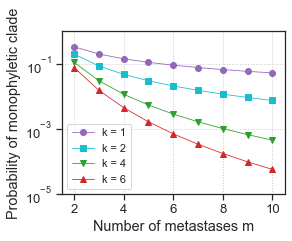

In [8]:
# Create figure demonstrating the relationship between root diversity score
# with the number of metastases samples and remaining cancer samples (Fig. 1f)

# create figure for paper or presentation
with sns.axes_style("white", {'axes.grid': True, 'grid.linestyle': u':', 
                              'xtick.labelsize': 13, 'ytick.labelsize': 10}):
    
    # defines the size of the plot
    fig, ax = plt.subplots(figsize=fig_size)

    # markers for the different lines creates by the different values of k
    markers = cycle(['o', 's', 'v', '^', 'p', '*', 'D', 'x'])

    # data structure to save many values
    x_values = defaultdict(list)
    y_values = defaultdict(list)
    xlims = [1.5, no_mets+0.5]

    # loop through the number of PT samples
    # for k in range(1, no_pts+1):
    for i, k in enumerate(pt_samples, 1):
        # loop through the number met samples
        for m in range(2, no_mets+1):
            x_values[k].append(m)
            y_values[k].append(cluster_probability(k, m))

        color = reordered_colors[i-1]
        plt.plot(x_values[k], y_values[k], 'k', lw=0.8, marker=next(markers), markersize=6, 
                 markevery=1, markeredgecolor=color, markerfacecolor=color,
                 color=color, label='k = {}'.format(k))

    ax.set_xlim(xlims)
    ax.set_xlabel('Number of metastases m')
    ax.set_ylim([1e-5, 1])
    ax.set_yscale('log')
    ax.set_ylabel('Probability of monophyletic clade')
    
    ax.xaxis.set_tick_params(which='major', left=True)
    ax.yaxis.set_tick_params(which='major', left=True)

    leg = ax.legend(loc='lower left', fontsize=11, frameon=True)
    frame = leg.get_frame()
    frame.set_facecolor('w')

    plt.savefig('fig_fraction_monophyletic_trees_k={}_m={}.pdf'.format(max(x_values.keys()), max(x_values[1])), 
                dpi=150, bbox_inches='tight', transparent=True)

### Apply RDS formula to data extracted from Kim et al, Clin Cancer Res 2015 and Naxerova et al, Science 2017 

In [9]:
def read_topology_data(fp):
    """
    Read supplementary tables with topology information
    :param fp: path to Supplementary Table
    """
    try:
        df = pd.read_excel(fp)

    except FileNotFoundError:
        print('ERROR: File {} needs to be in the same folder!'.format(fp))
        raise

    # apply calculations to patients with at least two metastases
    df = df[(df.m > 1)]
    # calculate the root diversity score
    df['RDS'] = df.apply(
        lambda row: rds(int(row.k), int(row.m), int(row.l)), axis=1)
    df['log_RDS'] = df.apply(lambda row: np.log10(row['RDS']), axis=1)
    df.to_csv('RDS.csv', index=False)
    
    return df

def plot_comparison(df, x, y, order, ylabel, filepath=None, title=None): 
    """
    Create boxplot to compare the Root Diversity Score of distant and lymphatic metastases
    :param df: pandas dataframe with columns 'Metastasis type', 'm', and 'RDS'
    :param filepath: path to file where the boxplot should be saved as PDF file
    :param title: optional title of the plot
    """
        
    # run Kruskal-Wallis H-test if more than two samples are compared
    if len(df[x].unique()) > 2:
        # unpack list of samples before calling function
        kwhs = kruskal(*[df[(df[x] == c)][y].values for c in df[x].unique()])
        print('Kruskal-Wallis H statistic {:.3e}, p-value {:.3e} among {}'.format(
            kwhs[0], kwhs[1], ', '.join(f'{c} ({df[(df[x] == c)][y].count()})' for c in df[x].unique())))
        
        # check whether there are any pairwise differences after the Kruskal-Wallis H-test rejected the null hypothesis
        if kwhs[1] <= 0.05:
            # run Conover's test and adjust for multi-hypotheses testing using the Holm-Bonferroni method
            print('Conover\'s test with multi-hypotheses testing correction')
            print(sp.posthoc_conover(df, val_col=y, group_col=x, p_adjust='fdr_bh'))
            
#             # Optional compare with other statistics
#             # run Mann-Whitney test and adjust for multi-hypotheses testing using the Holm-Bonferroni method
#             print('Mann-Whitney test with multi-hypotheses testing correction')
#             print(sp.posthoc_mannwhitney(df, val_col=y, group_col=x, p_adjust='fdr_bh'))
#             # run Dunn's test and adjust for multi-hypotheses testing using the Holm-Bonferroni method
#             print('Dunn\'s test with multi-hypotheses testing correction')
#             print(sp.posthoc_dunn(df, val_col=y, group_col=x, p_adjust='fdr_bh'))

    # run Mann-Whitney U-test if only two categories are compared
    else:
        for c1, c2 in combinations(df[x].unique(), 2):
            scores1 = df[(df[x] == c1)][y].values
            scores2 = df[(df[x] == c2)][y].values
            mwus = mannwhitneyu(scores1, scores2, alternative='two-sided')
            print('{} (#{}) vs {} (#{}) metastasis {} (mean: {:.4f} vs {:.4f}) Mann-Whitney U statistic {}, p-value {:.4e}'.format(
                c1, len(scores1), c2, len(scores2), y, np.nanmean(scores1), np.nanmean(scores2), mwus[0], mwus[1]))

    for metastasis_type in sorted(df[x].unique(), reverse=True):
        print('Mean and median number of {} metastases for subjects with at least 2 {} metastases: {:.3f}, {}'.format(
        metastasis_type, metastasis_type, np.mean(df[(df[x] == metastasis_type)]['m']), 
        np.median(df[(df[x] == metastasis_type)]['m'])))

    # show mean as a diamond
    meanpointprops = dict(marker='d', markeredgecolor='black', markeredgewidth=0.2,
                          markerfacecolor='magenta', markersize=9)
    
    sns.set(font_scale = 1.1)
    with sns.axes_style("white", {'axes.grid': False, 'grid.linestyle': u':', 
                                  'xtick.labelsize': 13, 'ytick.labelsize': 10,
                                  'ytick.major.size': 4.0}):

        f, ax = plt.subplots(figsize=(2.2, 2.5))
        sns.boxplot(x=x, y=y, data=df, palette=colors,
                    order=order,
                    showmeans=True, meanprops=meanpointprops, orient="v", width=0.7, ax=ax)
        sns.swarmplot(x=x, y=y, data=df, 
                      order=order,
                      color=".3", size=6, ax=ax)
        
        ax.set(xlabel='', ylabel=ylabel);
        ax.grid(False)
        ax.yaxis.set_tick_params(which='major', left='on')
        if y == 'RDS':
            ax.set(ylim=(-0.04, 1.04));
            ax.set_yticks(np.linspace(0, 1, 6))
        else:
            ax.set(ylim=(-3, 103));
            
        sns.despine(left=False)
        
        if any(len(label) > 10 for label in df[x].unique()):
            plt.xticks(rotation=45)
        
        if title is not None:
            ax.set_title(title)
        
        if filepath is not None:
            plt.savefig(filepath, dpi=150, 
                        bbox_inches='tight', transparent=True)
            
# classify metastasis additionally by treatment
lymph_untr = 'untreated lymphatic'
lymph_tr = 'treated lymphatic'
dist_untr = 'untreated distant'
dist_tr = 'treated distant'

def add_treatment_classification_col(df):
    mets_treatment = list()
    for index, row in df.iterrows():
        if row['Metastasis type'] == 'Distant':
            if row['Completely untreated'] == True:
                mets_treatment.append(dist_untr)
            else:
                mets_treatment.append(dist_tr)
                
        elif row['Metastasis type'] == 'Lymphatic':
            if row['Completely untreated'] == True:
                mets_treatment.append(lymph_untr)
            else:
                mets_treatment.append(lymph_tr)

    df['Metastasis_treatment'] = mets_treatment
    return df

### Analysis of original cohort

Lymphatic (#10) vs Distant (#11) metastasis RDS (mean: 0.6945 vs 0.0904) Mann-Whitney U statistic 98.0, p-value 2.5836e-03
Mean and median number of Lymphatic metastases for subjects with at least 2 Lymphatic metastases: 3.700, 3.0
Mean and median number of Distant metastases for subjects with at least 2 Distant metastases: 3.182, 3.0


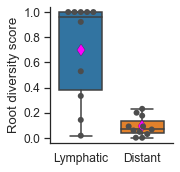

In [10]:
# ################################# ORIGINAL COHORT ###################################
# read data of original cohort
df_mets = read_topology_data(topology_fp)

# creates Fig. 1h showing root diversity score for lymphatic and distant metastases
plot_comparison(df_mets, x='Metastasis type', y='RDS', order=['Lymphatic', 'Distant'],
                ylabel='Root diversity score', filepath='pnl_metastasis_RDS_LNvsDM.pdf')

In [11]:
# Calculate a combined p-value for the computed root diversity scores of distant metastases

# require a minimum of 2 samples from distant metastases and 2 remaining cancer samples
min_met_samples = 2
min_pt_samples = 2
min_n_samples = 0
    
df_dms = df_mets[(df_mets['Metastasis type'] == 'Distant') 
                & (df_mets.m >= min_met_samples) 
                & (df_mets.k >= min_pt_samples)]

print('Remaining cohort size with at least {} PT samples and {} met samples: {}, median mets {}, median other samples {}, mean mets {:.3f}, mean others {:.3f}'.format(
    min_pt_samples, min_met_samples, len(df_dms.Patient.unique()), np.median(df_dms.m), 
    np.median(df_dms.k), np.mean(df_dms.m), np.mean(df_dms.k)))
print('Combined cohort p-value of all subjects by using Fisher`s method: {:.3e}'.format(
    combine_pvalues(df_dms['RDS'])[1]))
print('Combined cohort p-value of untreated subjects by using Fisher`s method: {:.3e}'.format(
    combine_pvalues(df_dms[~df_dms['Completely untreated']]['RDS'])[1]))

Remaining cohort size with at least 2 PT samples and 2 met samples: 11, median mets 3.0, median other samples 5.0, mean mets 3.182, mean others 5.091
Combined cohort p-value of all subjects by using Fisher`s method: 4.501e-07
Combined cohort p-value of untreated subjects by using Fisher`s method: 1.247e-02


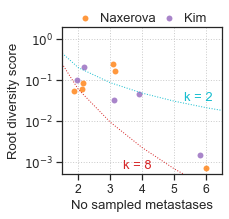

In [12]:
# Create figure illustrating the decreasing root diversity score 
# with an increasing number of metastases samples (Fig. 1g)

# calculate min score lines for two and six remaining cancer samples to put the RDS into context
p_low_min_scores = list()
p_high_min_scores = list()
xs = np.linspace(1, 7, 7)
for m in xs:
    p_low_min_scores.append(rds(2, m, m))
    p_high_min_scores.append(rds(8, m, m))
    
with sns.axes_style("white", {'axes.grid': True, 'grid.linestyle': u':', 
                              'xtick.labelsize': 13, 'ytick.labelsize': 10,
                              'xtick.major.size': 4.0, 'ytick.major.size': 4.0}):
    
    fg = sns.lmplot(data=df_dms, x='m', y='log_RDS', 
                    hue='Dataset', hue_order=['Naxerova', 'Kim'], 
                    palette=[colors[1], colors[4]],
                    height=3.0, aspect=1.1, x_jitter=0.2, y_jitter=0.04,
                    scatter_kws={'s': 35, 'alpha': 0.8, 'linewidth': 0.0}, 
                    fit_reg=False, legend=False
                    )
    
    fg.ax.legend(loc=1, bbox_to_anchor=(0.975, 1.18), fontsize=13, ncol=2, 
                 labelspacing=0.4, columnspacing=0.8, handlelength=0.6, 
                 frameon=False, labels=['Naxerova', 'Kim'])
    
    ylim_min = -3
    fg.set(xlim=(1.5, 6.5), ylim=(ylim_min-0.3, 0.3))
    fg.set(xlabel='No sampled metastases', ylabel='Root diversity score')
    fg.set(xticks=np.linspace(2, 6, 5))
    
    string_labels = []
    for i in range(0,ylim_min-2, -1):
        string_labels.append(r'$10^{{{}}}$'.format(i))
    fg.set(yticklabels=string_labels[::-1])
    fg.fig.get_axes()[0].xaxis.set_tick_params(which='major', left=True)
    fg.fig.get_axes()[0].yaxis.set_tick_params(which='major', left=True)
    sns.despine(left=False, right=False, top=False, bottom=False)
    
    # add min score line for two remaining cancer samples
    fg.axes[0][0].plot(xs, np.log10(p_low_min_scores), 
                       color=colors[9], linestyle=':', linewidth=1)
    fg.axes[0][0].text(5.3, np.log10(p_low_min_scores[-3]), 'k = 2', fontsize=13, color=colors[9])
    
    # add min score line for eight remaining cancer samples
    fg.axes[0][0].plot(xs, np.log10(p_high_min_scores), 
                       color=colors[3], linestyle=':', linewidth=1)
    fg.axes[0][0].text(3.4, np.log10(p_high_min_scores[-3]), 'k = 8', fontsize=13, color=colors[3])
    
    plt.savefig('pnl_rds_2d.pdf', dpi=150, bbox_inches='tight', transparent=True)

Kruskal-Wallis H statistic 1.037e+01, p-value 5.594e-03 among untreated lymphatic (9), treated distant (5), untreated distant (6)
Conover's test with multi-hypotheses testing correction
                     treated distant  untreated distant  untreated lymphatic
treated distant            -1.000000           0.239931             0.018967
untreated distant           0.239931          -1.000000             0.001310
untreated lymphatic         0.018967           0.001310            -1.000000
Mean and median number of untreated lymphatic metastases for subjects with at least 2 untreated lymphatic metastases: 3.889, 3.0
Mean and median number of untreated distant metastases for subjects with at least 2 untreated distant metastases: 4.000, 3.5
Mean and median number of treated distant metastases for subjects with at least 2 treated distant metastases: 2.200, 2.0


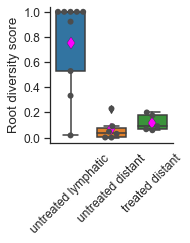

In [13]:
# creates Fig. 1i showing root diversity score for lymphatic and distant metastases stratified by treatment
# statistical comparison corrected for multi-hypothesis testing
df_mets = add_treatment_classification_col(df_mets)
plot_comparison(df_mets[df_mets['Metastasis_treatment'] != lymph_tr], x='Metastasis_treatment', y='RDS',
                order=[lymph_untr, dist_untr, dist_tr],
                ylabel='Root diversity score',
                filepath='pnl_metastasis_RDS_LNvsDMutrdvsDMtrd.pdf')
# #################### END ORIGINAL COHORT ###########################################

### Analysis of validation cohort

Distant (#9) vs Lymphatic (#14) metastasis RDS (mean: 0.1494 vs 0.5272) Mann-Whitney U statistic 24.5, p-value 1.6381e-02
Mean and median number of Lymphatic metastases for subjects with at least 2 Lymphatic metastases: 6.000, 5.0
Mean and median number of Distant metastases for subjects with at least 2 Distant metastases: 3.667, 4.0


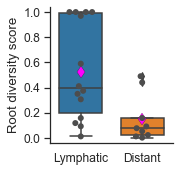

In [14]:
# #################################### VALIDATION COHORT #####################################
# read data of validation cohort
df_mets_val = read_topology_data(topology_fp_val)

# creates Fig. 2g showing root diversity score for lymphatic and distant metastases
plot_comparison(df_mets_val, x='Metastasis type', y='RDS', order=['Lymphatic', 'Distant'],
                ylabel='Root diversity score', filepath='pnl_metastasis_RDS_LNvsDM_validation.pdf')

Kruskal-Wallis H statistic 6.055e+00, p-value 4.843e-02 among treated distant (5), untreated distant (4), untreated lymphatic (12)
Conover's test with multi-hypotheses testing correction
                     treated distant  untreated distant  untreated lymphatic
treated distant            -1.000000           0.241771             0.262797
untreated distant           0.241771          -1.000000             0.038385
untreated lymphatic         0.262797           0.038385            -1.000000
Mean and median number of untreated lymphatic metastases for subjects with at least 2 untreated lymphatic metastases: 6.583, 5.0
Mean and median number of untreated distant metastases for subjects with at least 2 untreated distant metastases: 3.250, 3.0
Mean and median number of treated distant metastases for subjects with at least 2 treated distant metastases: 4.000, 4.0


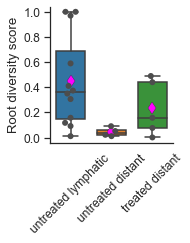

In [15]:
# creates Fig. 2j showing root diversity score for lymphatic and distant metastases stratified by treatment
# statistical comparison corrected for multi-hypothesis testing
df_mets_val = add_treatment_classification_col(df_mets_val)
plot_comparison(df_mets_val[df_mets_val['Metastasis_treatment'] != lymph_tr], 
                x='Metastasis_treatment', y='RDS',
                order=[lymph_untr, dist_untr, dist_tr],
                ylabel='Root diversity score',
                filepath='pnl_metastasis_RDS_LNvsDMutrdvsDMtrd_validation.pdf')

# ################################# END VALIDATION COHORT ###################################

### Analysis of combined cohort

Lymphatic (#24) vs Distant (#20) metastasis RDS (mean: 0.5969 vs 0.1170) Mann-Whitney U statistic 413.5, p-value 4.2084e-05
Mean and median number of Lymphatic metastases for subjects with at least 2 Lymphatic metastases: 5.042, 4.5
Mean and median number of Distant metastases for subjects with at least 2 Distant metastases: 3.400, 3.0


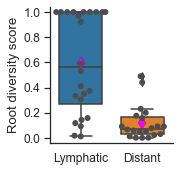

In [16]:
# #################################### COMBINED COHORTS #####################################
# combine original cohort and validation cohort
df_mets_combined = pd.concat([df_mets, df_mets_val])

# creates Fig. 2h showing root diversity score for lymphatic and distant metastases
plot_comparison(df_mets_combined, x='Metastasis type', y='RDS', order=['Lymphatic', 'Distant'],
                ylabel='Root diversity score', filepath='pnl_metastasis_RDS_LNvsDM_combined.pdf')

Lymphatic (#15) vs Distant (#15) metastasis Bootstrap value for l branch [%] (mean: 57.4333 vs 80.6000) Mann-Whitney U statistic 58.0, p-value 2.5071e-02
Mean and median number of Lymphatic metastases for subjects with at least 2 Lymphatic metastases: 6.267, 5.0
Mean and median number of Distant metastases for subjects with at least 2 Distant metastases: 3.400, 3.0


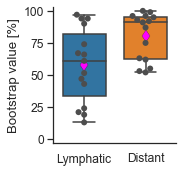

In [17]:
# creates Fig. 2i comparing bootstrap values of the l branch (largest cluster of metastases)
plot_comparison(df_mets_combined.dropna(subset=['Bootstrap value for l branch [%]']), 
                x='Metastasis type', y='Bootstrap value for l branch [%]', 
                order=['Lymphatic', 'Distant'],
                ylabel='Bootstrap value [%]', filepath='pnl_metastasis_bootstrap_LNvsDM_combined.pdf')

Kruskal-Wallis H statistic 1.756e+01, p-value 1.541e-04 among untreated lymphatic (21), treated distant (10), untreated distant (10)
Conover's test with multi-hypotheses testing correction
                     treated distant  untreated distant  untreated lymphatic
treated distant            -1.000000           0.057309             0.007197
untreated distant           0.057309          -1.000000             0.000017
untreated lymphatic         0.007197           0.000017            -1.000000
Mean and median number of untreated lymphatic metastases for subjects with at least 2 untreated lymphatic metastases: 5.429, 5.0
Mean and median number of untreated distant metastases for subjects with at least 2 untreated distant metastases: 3.700, 3.5
Mean and median number of treated distant metastases for subjects with at least 2 treated distant metastases: 3.100, 2.5


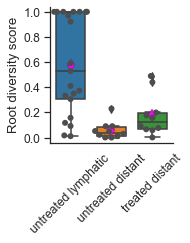

In [18]:
# creates Fig. 2j showing root diversity score for lymphatic and distant metastases stratified by treatment
# statistical comparison corrected for multi-hypothesis testing
plot_comparison(df_mets_combined[df_mets_combined['Metastasis_treatment'] != lymph_tr], 
                x='Metastasis_treatment', y='RDS',
                order=[lymph_untr, dist_untr, dist_tr],
                ylabel='Root diversity score',
                filepath='pnl_metastasis_RDS_LNvsDMutrdvsDMtrd_combined.pdf')

treated distant (#10) vs untreated distant (#10) metastasis RDS (mean: 0.1760 vs 0.0580) Mann-Whitney U statistic 78.0, p-value 3.7348e-02
Mean and median number of untreated distant metastases for subjects with at least 2 untreated distant metastases: 3.700, 3.5
Mean and median number of treated distant metastases for subjects with at least 2 treated distant metastases: 3.100, 2.5


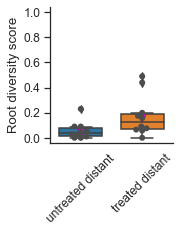

In [19]:
# creates Fig. 2k comparing root diversity score for untreated and treated distant metastases
plot_comparison(df_mets_combined[(df_mets_combined['Metastasis_treatment'] != lymph_tr) &
                                 (df_mets_combined['Metastasis_treatment'] != lymph_untr)], 
                x='Metastasis_treatment', y='RDS',
                order=[dist_untr, dist_tr],
                ylabel='Root diversity score',
                filepath='pnl_metastasis_RDS_DMutrdvsDMtrd_combined.pdf')

# #################################### END COMBINED COHORTS #####################################